Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
%matplotlib inline

# Part 1: The seven scientists

This example is due to [MacKay 2003, exercise 22.15] and [Lee & Wagenmaker 2013, section 4.2].

Suppose seven scientists all go and perform the same experiment, each collecting a measurement $x_i$ for $i = 1,\dots,7$, of an underlying physical value $\mu$. 
 
These scientists are varyingly good at their job, and while we can assume each scientist would estimate $\mu$ correctly _on average_, some of them may have much more error in their measurements than others.

They come back with the following seven observations:


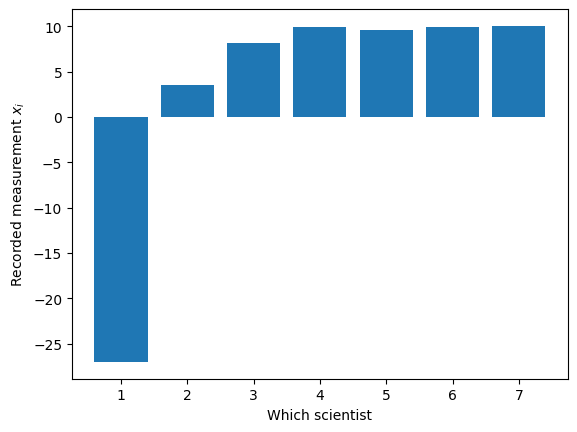

In [2]:
measurements = torch.FloatTensor([-27.020, 3.570, 8.191, 9.898, 9.603, 9.945, 10.056])

plt.bar(np.arange(1,8), measurements) # , "o")
plt.xlabel("Which scientist")
plt.ylabel("Recorded measurement $x_i$");

From looking at the plot, clearly one scientist does not know what they are doing (and some of the others are probably a little suspect too)!


### A model for the data

In this exercise we will suppose that there is "scientist-specific" standard deviation $\sigma_i$, which describes how accurately each of them might perform the experiment:

$$\begin{align}
x_i &\sim \mathrm{Normal}(\mu, \sigma_i^2).
\end{align}$$

Scientists with low $\sigma_i$ produce good estimates of $x$, whereas scientists with high $\sigma_i$ might have wildly inaccurate estimates. However, we don't know _which_ scientists are good -- and we only have one observation from each!

We can ask two questions:

* What is the "real" value of $\mu$?
* What are the values of $\sigma_i$ for each scientists?



### Bayesian inference approach

You will have to choose priors for the mean $\mu$ of the measurements, and for the error standard deviation $\sigma\_i$ for each of the $i$ scientists. A good starting point is

$$\begin{align}
\mu &\sim \mathrm{Normal}(0, \alpha^2) \\
\sigma_i &\sim \mathrm{Exponential}(\beta)
\end{align}$$

where $\alpha=50$ and $\beta=0.5$. This is a prior distribution with mean 2 that places diminishing probability density on larger values of $\sigma_i$:


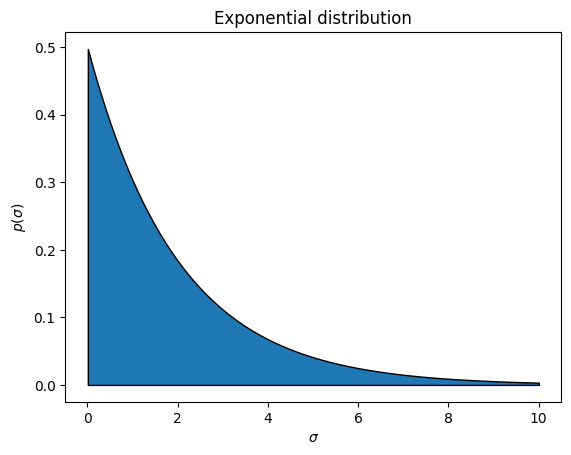

In [3]:
plt.fill_between(np.linspace(0.01,10,100), 0.0, 
                 dist.Exponential(rate=0.5).log_prob(torch.linspace(0.01,10,100)).exp(), 
                 edgecolor='k');
plt.xlabel("$\sigma$")
plt.ylabel("$p(\sigma)$")
plt.title("Exponential distribution");

# TASK #1 (3 points): Define the model

Given $\alpha=50, \beta=0.5$, and the measurements $x$ above, write a function to compute the unnormalized log density

$$\log p(\mu, x_1,\dots,x_7, \sigma_1,\dots, \sigma_7 | \alpha, \beta)$$

In [4]:
def log_joint(mu, sigma, alpha=50, beta=0.5):
    """
    INPUT:
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0
    alpha : scalar, standard deviation of Gaussian prior on mu. Default to 50
    beta  : scalar, rate of exponential prior on sigma_i. Default to 0.5

    OUTPUT:
    log_joint: the log probability log p(mu, sigma, x | alpha, beta), scalar
    
    NOTE: For inputs where sigma <= 0, please return negative infinity!

    """
    #assert mu.ndim == 0
    #assert sigma.shape == (7,)
    
    # p(mu, sigma, x | alpha, beta) = p(x | mu, sigma) p(mu | alpha) p(sigma | beta)
    
    # p(sigma | beta)
    log_prior_sigma = dist.Exponential(beta).log_prob(sigma).sum(0)
    # print(log_prior_sigma)
    
    # p(mu | alpha)
    log_prior_mu = dist.Normal(0,alpha**2).log_prob(mu).sum(0)
    # print('mu', log_prior_mu)
    
    # p(x | mu, sigma)
#     log_like = 0.0
#     for i in range(7): 
#         if sigma[i] <= 0:
#             return - float(inf)
#         else:
#             x_i = dist.Normal(mu, sigma[i]).log_prob(measurements)
#             log_like += dist.Normal(mu, sigma[i]).log_prob(x_i).sum(0)
    
    log_like = dist.Normal(mu, sigma).log_prob(measurements).sum(0)
    # print('log_like', log_like)
    
    log_xms = log_like + log_prior_mu + log_prior_sigma
    
    return log_xms

#### Ignore the following cells. 

They consist of "hidden" test cases, and are used by the grading system.

In [5]:
# (GRADING)

In [6]:
# (GRADING)

# TASK #2 (5 points): Implement an MCMC sampler

Your second task is to implement an MCMC algorithm to sample from the posterior distribution

$$p(\mu, \sigma | x, \alpha, \beta).$$

To do this, you need to implement two functions:

* `get_mcmc_proposal`: this takes in current values of $\mu$ and $\sigma$, and returns pytorch `Distribution` objects (i.e., `torch.distributions.Distribution`, here in-scope as `dist.Distribution`) that will propose a next value given the current value, $q(\mu' | \mu, \dots)$ and $q(\sigma' | \sigma, \dots)$. It is **your choice** what sort of distribution to use here! Just make sure that whatever you propose works well in your MCMC algorithm.

* `mcmc_step`: this takes in current values of $\mu$ and $\sigma$, and runs a single Metropolis-Hastings step:
  1. sample candidate values from the proposal distribution you defined
  2. compute an acceptance probability, and either accept or reject
  3. return $\mu, \sigma$

In [16]:
def get_mcmc_proposal(mu, sigma):
    """
    INPUT:
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0

    OUTPUT:
    q_mu    : instance of Distribution class, that defines a proposal for mu
    q_sigma : instance of Distribution class, that defines a proposal for sigma
    """
    
    mu_vari = 0.0
    for i in range(7): 
        if sigma[i] > 0:
            x_i = dist.Normal(mu, sigma[i]).sample()
            mu_vari += abs(mu - x_i)
        else:
            return "OUT OF RANGE"
    
    alpha = mu_vari / 5.75
    beta = sigma*torch.eye(sigma.shape[0])
    
    
    q_mu = dist.Normal(mu, alpha)
    q_sigma = dist.MultivariateNormal(sigma, beta*0.09)
    
    
    return q_mu, q_sigma


### Quick self-check!

If your `get_mcmc_proposal` has the correct function signature, all the following assertions should be true:

In [17]:
q_mu, q_sigma = get_mcmc_proposal(torch.tensor(9.0), torch.ones(7))
assert isinstance(q_mu, dist.Distribution)
assert isinstance(q_sigma, dist.Distribution)
assert q_mu.sample().shape == ()
assert q_sigma.sample().shape == (7,)
del q_mu, q_sigma

In [18]:
def mcmc_step(mu, sigma, alpha=50, beta=0.5):
    """
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0
    alpha : scalar, standard deviation of Gaussian prior on mu. Default to 50
    beta  : scalar, rate of exponential prior on sigma_i. Default to 0.5

    OUTPUT:
    mu       : the next value of mu in the MCMC chain
    sigma    : the next value of sigma in the MCMC chain
    accepted : a boolean value, indicating whether the proposal was accepted

    """
    
    accepted = False
    q_mu, q_sigma = get_mcmc_proposal(mu, sigma)
    
    mu_proposal = q_mu.sample()
    sigma_proposal = q_sigma.sample()
    
    p_now = log_joint(mu, sigma, 50, 0.5)
    
    try: 
        p_new = log_joint(mu_proposal, sigma_proposal, 50, 0.5)
    except ValueError:
        p_new = - torch.inf
        
    if p_new - p_now > torch.rand(1).log().item():
        accepted = True
        return mu_proposal, sigma_proposal, accepted
    else:
        return mu, sigma, accepted

## Running MCMC

We've supplied the outer loop for you -- it will call and execute your `mcmc_step` function. You should *not* need to edit it!

You do need to fill in the function `algo_parameters`, though, which just returns the total number of iterations you decide to run the MCMC chain, and the number of samples to discard as "burnin".

In [19]:
def run_mcmc(N_iters, mu_init, sigma_init):
    """ Run an MCMC algorithm for a fixed number of iterations """
    
    mu_chain = [mu_init]
    sigma_chain = [sigma_init]
    N_accepted = 0
    for _ in range(N_iters):
        mu, sigma, accepted = mcmc_step(mu_chain[-1], sigma_chain[-1])
        mu_chain.append(mu)
        sigma_chain.append(sigma)
        N_accepted += accepted
    
    return torch.stack(mu_chain), torch.stack(sigma_chain), N_accepted / N_iters

In [20]:
def algo_parameters():
    """ TODO: set these to appropriate values:
    
    OUTPUT:
    N_samples : total number of MCMC steps
    N_burnin  : number of initial steps to discard
    """
    
    
    N_samples = 25000
    N_burnin = 2500
    
    return N_samples, N_burnin

## Initialize, run, and display diagnostics

The following code initializes the MCMC sampler, executes it for the number of iterations you specified, and then plots a handful of diagnostics.

Use these diagnostics to decide whether or not you have done this properly! Take some time to try to interpret the results, and feel free to play around with the plots a bit.

In [21]:
mu_init = measurements.mean()
sigma_init = torch.ones(7)

N_samples, N_burnin = algo_parameters()

mu_chain, sigma_chain, accepted = run_mcmc(N_samples, mu_init, sigma_init)
print("acceptance rate:", accepted)

acceptance rate: 0.01944


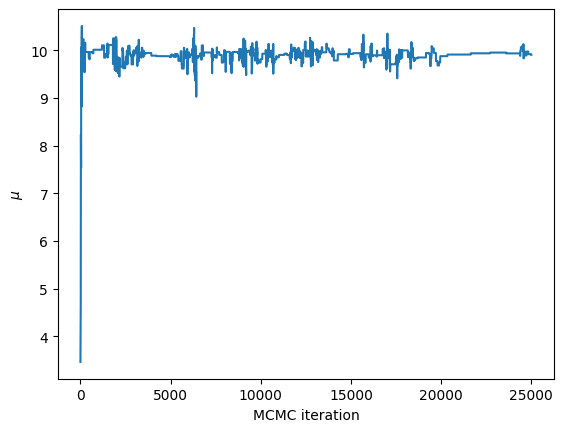

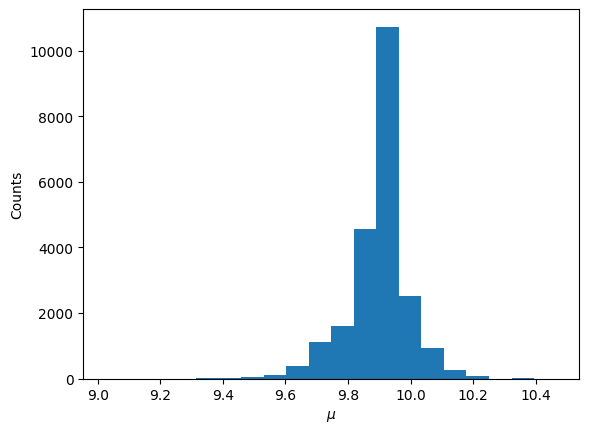

In [22]:
plt.plot(mu_chain);
plt.xlabel("MCMC iteration");
plt.ylabel("$\mu$")
plt.figure();
plt.hist(mu_chain[N_burnin:].numpy(), bins=20);
plt.xlabel("$\mu$")
plt.ylabel("Counts");

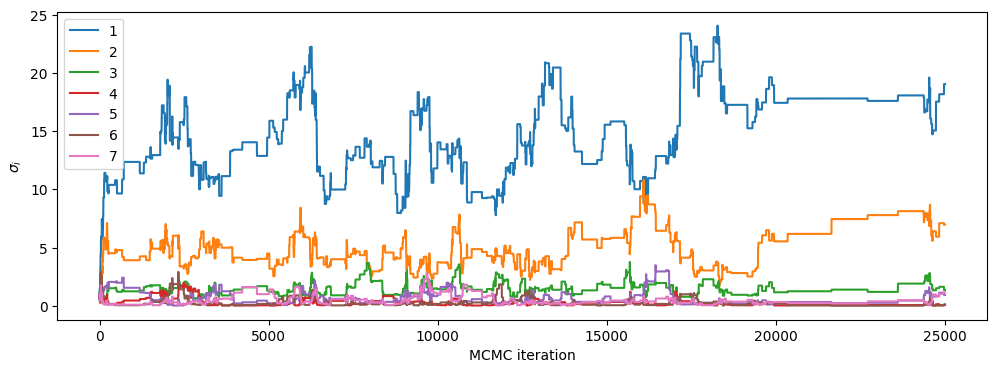

In [23]:
plt.figure(figsize=(12,4));
plt.plot(sigma_chain)
plt.legend(range(1,8));
plt.xlabel("MCMC iteration")
plt.ylabel("$\sigma_i$");

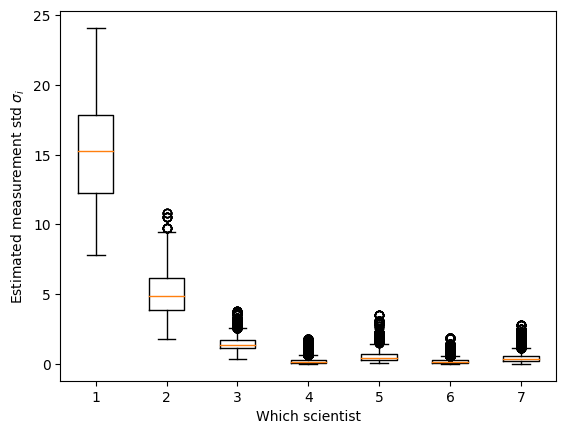

In [24]:
plt.boxplot(sigma_chain[N_burnin:].T, positions=np.arange(1, 8));
plt.xlabel("Which scientist")
plt.ylabel("Estimated measurement std $\sigma_i$");

# TASK #3 (2 points): Estimate posterior expectations

We're specifically interested in using the samples to answer the following:

1. What is the expected value of $\mu$, i.e., $\mathbb{E}[\mu ]$, under the posterior distribution?
2. What is the posterior probability that $\mu$ is less than 9, i.e. $\Pr(\mu < 9.0)$?

Both of these questions can be answered by using samples from your MCMC chain.

In [25]:
def estimate_E_mu(mu_chain, sigma_chain, N_burnin):
    """ Estimate E[mu] 
    
    INPUTS:
    mu_chain    : sequence of MCMC samples of mu
    sigma_chain : sequence of MCMC samples of sigma 
    N_burnin    : number of initial MCMC samples to discard as burnin 
    
    OUTPUTS:
    mu : expected value of mu (scalar)
    """
    
    mu_chain_burned = mu_chain[N_burnin:]
    sigma_chain_burned = sigma_chain[N_burnin:]
    
    steps = len(mu_chain_burned)
    
    E_mu = (1/steps)*mu_chain_burned.sum(0)
    
    return E_mu
    
def estimate_pr_mu_lt_9(mu_chain, sigma_chain, N_burnin):
    """ Estimate the posterior probability that mu is less than 9, i.e. Pr(mu < 9) 
    
    INPUTS:
    mu_chain    : sequence of MCMC samples of mu
    sigma_chain : sequence of MCMC samples of sigma 
    N_burnin    : number of initial MCMC samples to discard as burnin 
    
    OUTPUTS:
    estimate : estimate of Pr(mu < 9), a scalar
    """
    
    # P(mu < 9) = 1 - P(mu < 10)
    
    mean = estimate_E_mu(mu_chain, sigma_chain, N_burnin)
    std = estimate_E_mu(sigma_chain, mu_chain, N_burnin)
    

    def pdf(val, m, s):
        num = np.exp(-(val - m)**2 / (2*(s**2)))
        den = (2*torch.pi*(s**2))**(1/2)
        return num/den
    
    p_mu_lt_9 = 0.0
    for i in range(7):
        p_mu_lt_9 += pdf(9, mean, std[i])
    
    return p_mu_lt_9/7

In [26]:
print("E[mu] = %0.4f" % estimate_E_mu(mu_chain, sigma_chain, N_burnin))
print("Pr(mu < 9) = %0.4f" % estimate_pr_mu_lt_9(mu_chain, sigma_chain, N_burnin))

E[mu] = 9.9014
Pr(mu < 9) = 0.0980


# SHORT ANSWER SECTION (4 points)

Please answer the following 2 questions, for up to two points each:

1. Describe your choices of MCMC proposal distributions. How did you select them? How do you know they are "good"?
2. In your `mcmc_step`, we consider 8 random variables, $\mu, \sigma_1, \dots, \sigma_7$, but you probably implemented this using a single accept-reject step (i.e., you propose new values for all random variables, and then jointly accept all of them, or not). Suppose someone suggested instead proposing for each of these variables one-at-a-time sequentially, including a separate accept-reject step after each. Might this be a good idea, and why or why not?

1. 

SELECTION

$\boldsymbol{\alpha}$: Heuristically, I considered that as the steps MCMC steps progress, the mu will (should) be converging about the true mean. Since the value of mu is real-valued and could be either positive or negative, I decided to give it a normal proposal distribution. I then set the mean of the proposal to the current, updated value of mu so that the proposal would take into account the previous steps. As for mu's proposal distribution's variance, I considered that the certainty in the crrent mu has been reinforced with each step taken so far. I thought that the variance of the mean, alpha, should decrease in direct relation with this certainty. This motivated the assignment of alpha proportional to the current value of mu and its difference from the X samples at that time step. I represented this thought can be represented in the general proportion $\alpha \propto (X-\mu)$. After assigning the proportion, it came down to tuning the relationship constant. 

$\boldsymbol{\beta}$ Similar to the reasoning behind behind the proposal distribution of mu, since sigma is a real-valued and we were told it was initialized intelligently, I decided to propose a a new distribution about the current sigma. As for the variance of sigma, defined by beta, I make this value small enough so that it would not be able to be negative unless it was below almost 6 standard deviations below the chosen initial value of beta. 

Both the propotion constant in the calculation of $\alpha$ and the small value of $\beta$ were tuned as in many runs of the model to determine the best fitting hyperparameters and their combination.


"GOOD"?

I know that my selection of alpha and beta work by the resulting convergence of mu and sigma and their distributions. Mu converged to a narrow yet encompassing normal distribution about a clear mean that makes sense with out data. As for sigma, each value converged well for the different scientists, reflecting the measurements of the scientist's experiment performance accuracy. 

2. FULL VS TOTAL UPDATE

I think this would be a fine idea, if they had a powerful computer and were not worried about the run-time. If it were me, however, I would inform them that on my computer, this would be disastrous. Additionally, adding to the model complexity, when this model appears to be adequately representative, goes again the Occam's Razor princple.

#### Ignore the following cells. They are used by the grading system.

In [27]:
# (GRADING)

In [28]:
# (GRADING)

In [29]:
# (GRADING)

In [30]:
# (GRADING)

In [31]:
# (GRADING)

# EXTRA CREDIT TASK #4 (2 points): Estimate $\alpha$ and $\beta$

Did we choose the hyperparameters $\alpha$ and $\beta$ well? Or were these poor selections?

One way of checking whether $\alpha$ and $\beta$ are set well is by computing a marginal likelihood estimate, i.e. estimating $p(x | \alpha, \beta)$ for different choices of $\alpha, \beta$.

However, a different option is to *also* perform Bayesian inference over $\alpha$ and $\beta$! To do this, we need to do three things:

1. Define a prior $p(\alpha, \beta)$
2. Define MCMC proposals $q(\alpha' | \alpha)$ and $q(\beta' | \beta)$
3. Update the MCMC algorithm itself to also sample $\alpha, \beta$.

To do this, this involves targeting the joint probability distribution

$$p(x,\mu,\sigma,\alpha,\beta) = p(x | \mu, \sigma)p(\mu | \alpha)p(\sigma | \beta)p(\alpha)p(\beta).$$

You can write your MCMC algorithm so that it alternates between doing updates on $\mu, \sigma$ (using your existing `mcmc_step` function) and doing updates on $\alpha, \beta$ (using a new `mcmc_step_hyperparams` function).

To do this you need to implement two things:

1. `log_prior_alpha_beta`: given $\alpha,\beta$, return $\log p(\alpha, \beta)$. You are free to define whatever sort of prior you think is appropriate.
2. `mcmc_step_hyperparams`: do a single MCMC step (including accept / reject) to update $\alpha, \beta$.

These will then be called by the `run_mcmc_bonus` function, below.

In [32]:
def log_prior_alpha_beta(alpha, beta):
    """
    Define a prior distribution on alpha, beta, and return its log probability
    
    INPUT:
    alpha : scalar, standard deviation of Gaussian distribution on mu
    beta  : scalar, rate of exponential distribution on sigma_i

    OUTPUT:
    log_prob : scalar, `log p(alpha, beta)`
    
    """
    
    log_prior_a = dist.Normal(45, 10).log_prob(alpha).sum(0)
    log_prior_b = dist.Normal(0.34, 0.05).log_prob(beta).sum(0)
    
    return log_prior_a + log_prior_b


In [33]:
def mcmc_step_hyperparams(mu, sigma, alpha, beta):
    """
    Run an MCMC step on alpha and beta
    
    INPUT:
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0
    alpha : scalar, standard deviation of Gaussian distribution on mu
    beta  : scalar, rate of exponential distribution on sigma_i

    OUTPUT:
    alpha    : the next value of alpha in the MCMC chain
    beta     : the next value of beta in the MCMC chain
    accepted : a boolean value, indicating whether the proposal was accepted
    
    """
    
    accepted = False
    q_mu, q_sigma = get_mcmc_proposal(mu, sigma)
    
    mu_proposal = q_mu.sample()
    sigma_proposal = q_sigma.sample()
    
    alpha_proposal = dist.Normal(45, 10).sample()
    beta_proposal = dist.Normal(0.34, 0.05).sample()

    
    p_now = log_joint(mu, sigma, alpha, beta) + log_prior_alpha_beta(alpha, beta)
    
    try: 
        p_new = log_joint(mu_proposal, sigma_proposal, alpha_proposal, beta_proposal) + log_prior_alpha_beta(alpha_proposal, beta_proposal)
    except ValueError:
        p_new = - torch.inf
        
    if p_new - p_now > torch.rand(1).log().item():
        accepted = True
        return alpha_proposal, beta_proposal, accepted
    else:
        return alpha, beta, accepted
    



### Run this MCMC algorithm, and plot the results.

What do you think?

1. Are these results qualitatively different?
2. Were the original choices of $\alpha, \beta$ reasonable?
3. How sensitive are these results to $\alpha, \beta$? To $p(\alpha, \beta)$?

In [34]:
def run_mcmc_bonus(N_iters, mu_init, sigma_init, alpha_init, beta_init):
    """ Run an MCMC algorithm for a fixed number of iterations.
    
    This also runs MCMC on "hyperparameters" alpha and beta.
    
    """
    
    mu_chain = [mu_init]
    sigma_chain = [sigma_init]
    alpha_chain = [alpha_init]
    beta_chain = [beta_init]
    for _ in range(N_iters):
        alpha, beta, accepted = mcmc_step_hyperparams(mu_chain[-1], sigma_chain[-1], alpha_chain[-1], beta_chain[-1])
        alpha_chain.append(alpha)
        beta_chain.append(beta)

        mu, sigma, accepted = mcmc_step(mu_chain[-1], sigma_chain[-1], alpha_chain[-1], beta_chain[-1])
        mu_chain.append(mu)
        sigma_chain.append(sigma)
    
    return torch.stack(mu_chain), torch.stack(sigma_chain), torch.stack(alpha_chain), torch.stack(beta_chain)

In [35]:
new_mu_chain, new_sigma_chain, alpha_chain, beta_chain = run_mcmc_bonus(N_samples, mu_chain[-1], sigma_chain[-1], torch.tensor(50.0), torch.tensor(0.5))

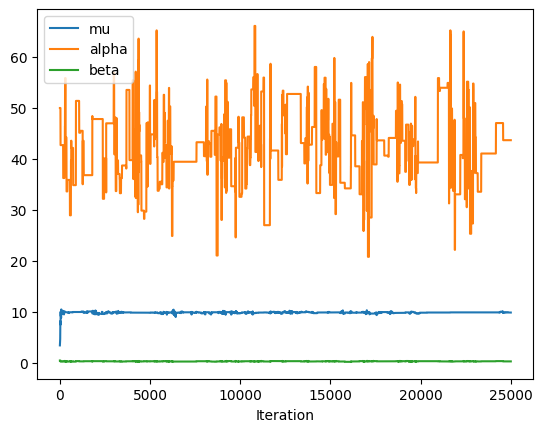

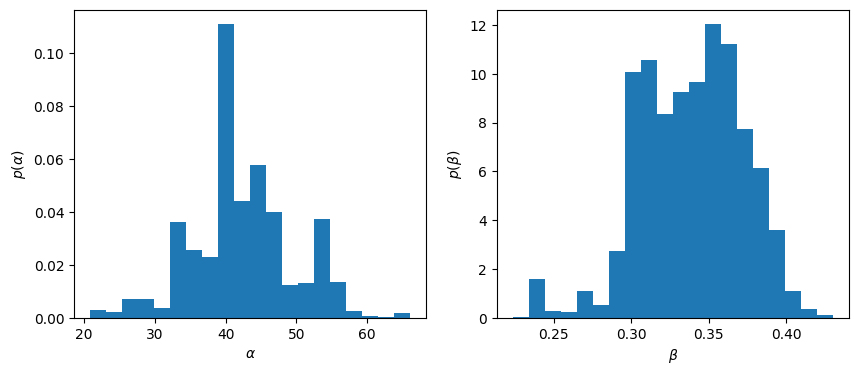

In [36]:
plt.plot(mu_chain)
plt.plot(alpha_chain);
plt.plot(beta_chain);
plt.legend(['mu', 'alpha', 'beta']);
plt.xlabel("Iteration");
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.hist(alpha_chain[N_burnin:].numpy(), bins=20, density=True);
plt.xlabel("$\\alpha$")
plt.ylabel("$p(\\alpha)$")
plt.subplot(122)
plt.hist(beta_chain[N_burnin:].numpy(), bins=20, density=True);
plt.xlabel("$\\beta$")
plt.ylabel("$p(\\beta)$");

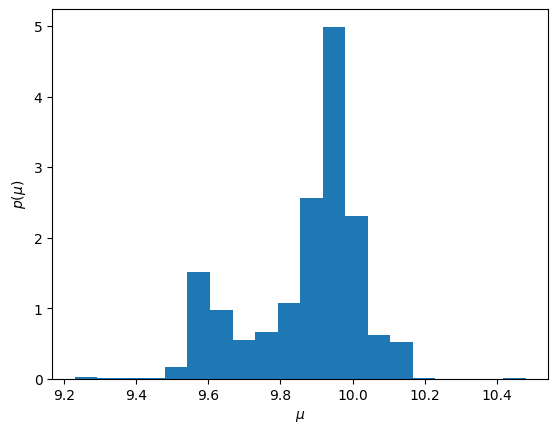

In [37]:
plt.hist(new_mu_chain[N_burnin:].numpy(), bins=20, density=True);
plt.xlabel("$\mu$")
plt.ylabel("$p(\mu)$");

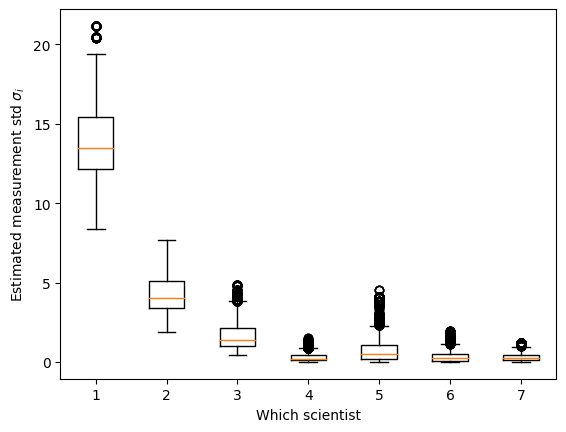

In [38]:
plt.boxplot(new_sigma_chain[N_burnin:].T, positions=np.arange(1, 8));
plt.xlabel("Which scientist")
plt.ylabel("Estimated measurement std $\sigma_i$");

1. Are the results qualitatively different?

The conclusions about the true mean and the "scientist-specific" standard deviations are the same. The resulting mean and sigma estimates of the 7 scientists in the MCMC run over the hyperparameters give results quantitatively equivalent to the MCMC run over the parameters. I do think that the hyperparameters were worth considering however, because they resulted in a more narrow and balanced distribution over mu and also provided an improved distribution over the scientists' standard deviations since about all points are included in the spread and the distributions about the value for each scientist is more even.

2. Were the original choices of $\alpha, \beta$ reasonable?

ALPHA
The original choice for alpha was reasonable. The original choicee was 50 and after running the MCMC over the hyperparameters above, alpha is estimated about 42 with a standard deviation of about 10, in which 50 falls within. 

BETA
At first glace, the original choice for beta also seems reasonable. The original choice being 0.5 and after running MCMC on the hyperparameters the beta estimate was about 0.34. Seems like two, relatively close, small numbers, however the one standard deviation is about 0.045, making 0.5 outside of two standard deviations from the mean, and highly unlikely.

3. How sensitive are these results to $\alpha, \beta$? To $p(\alpha, \beta)$?

These results were not too sensitive to alpha and beta, and required a lot more tuning than I originally imagined. I chose a large variation for alpha to see how it impacted the model results, but it did not make a difference qualitatively. Also, when both alpha and beta were better defined, the convergence seemed to occure more quickly, however with enough runs the parameter with the well defined hyperparameter did seem to converge well.

In [ ]:
# (GRADING)

In [ ]:
# (GRADING)